### Loading packages from config/init.py

In [1]:
%run ../config/init.py

### Testing AWS-cli configuration

In [2]:
access_key = !aws configure get aws_access_key_id
secret_access_key = !aws configure get aws_secret_access_key
if access_key and secret_access_key:
    print('Using access_key: ........{}'.format(access_key[0][10:]))
else:
    print('Please, configure AWS-cli before running this notebook')
    print('Open a Terminal and run: aws configure')

Using access_key: ........ZYMLD6V5WV


### Defining variables

Edit AWS zone and region variable accordingly to your geographical location.

In [62]:
REGION = 'us-east-1'
ZONE = 'us-east-1c'
!aws configure set region {REGION}

### Defining global Tags for identifying resources

Associate AWS Tags with each resource created by this notebook helps to compile total cost used by AWS.
The notebook will use, if exists, a file in the **CONFIG/aws** folder named: **aws-tags.json**

In [4]:
TAGFILE_S3 = None
TAGFILE = None
TAGDIR = None
if os.path.exists(os.path.join(CONFIG, "aws", "aws-tags-s3.json")):
    TAGFILE_S3 = os.path.join(CONFIG, "aws", "aws-tags-s3.json")
if os.path.exists(os.path.join(CONFIG, "aws", "aws-tags.json")):
    TAGFILE = os.path.join(CONFIG, "aws", "aws-tags.json")
    with open(TAGFILE) as fin:
        TAGDICT = json.loads(fin.read())
    PROJECT = None
    for k in TAGDICT['Tags']:
        if k['Key'] == 'Project':
            PROJECT = k['Value']
    if PROJECT:
        print("Using project tag: {}".format(PROJECT))

Using project tag: cbb-research-dl


### AWS machine types

| Instance Size | vCPU | Memory (GiB) | Instance Storage (GiB) | Network Bandwidth (Gbps) | EBS Bandwidth (Mbps) | $/Hour |
|---------|----------|----------|-------------|---------------|---------------|-----------|
| m5d.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 10 | 4,750 | 0.904 |
| m5d.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 10 | 6,800 | 1.808 |
| m5d.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 20 | 13,600 | 3.616 |
| m5dn.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 25 | 4,750 | 1.088 |
| m5dn.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 25 | 6,800| 2.176 |
| m5dn.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 75 | 13,600 | 4.352 |


 

In [122]:
QUERY_SIZES = [2000, 6000, 10000]

MACHINE_TYPES = ['m5d', 'm5dn']
CPUs = [
    {
        'name':'4xlarge',
        'CPUs': 16
    }, 
    {
        'name':'8xlarge',
        'CPUs': 32
    }, 
    {
        'name':'16xlarge',
        'CPUs': 64
    }]

# Prices from 03/04/2020
PRICE = {
    'm5d':{
        16: 0.904,
        32: 1.808,
        64: 3.616
    },
    'm5dn':{
        16: 1.088,
        32: 2.176,
        64: 4.352
    }    
}


In [6]:
result_dir = os.path.join(RESULTS, DATASET)
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)
print('Using as output directory: {}'.format(result_dir))

Using as output directory: /panfs/pan1.be-md.ncbi.nlm.nih.gov/alt_splicing/cloud-transcriptome-annotation/results/PRJNA320545


### Create or retrieve AWS S3 storage bucket

In [7]:
bucket_list = !aws s3 ls | awk '{print $3}'
buckets = {}
for q in QUERY_SIZES:
    prefix = 'nopal-' + str(q) + '-'
    suffix = None
    for l in bucket_list:
        if prefix in l:
            suffix = l.replace('nopal-' + str(q) + '-','')
            break
    if suffix:
        buckets[q] = suffix    

for q in QUERY_SIZES:
    if q not in buckets:
        suffix = str(uuid.uuid4())
        inbucket = 'nopal-' + str(q) + '-' + suffix
        outbucket = 'nopal-results-' + str(q) + '-' + suffix
        buckets[q] = suffix 
        
        !aws s3 mb s3://{inbucket} --region {REGION}          
        !aws s3 mb s3://{outbucket} --region {REGION}
        if TAGFILE_S3:
            !aws s3api put-bucket-tagging --bucket {inbucket} --tagging file://{TAGFILE_S3} 
            !aws s3api put-bucket-tagging --bucket {outbucket} --tagging file://{TAGFILE_S3} 
        !aws s3 cp {q}/fasta/ s3://{inbucket}/ --recursive
        
for q in buckets:
    print('Query size: {0}\n\tin-bucket: nopal-{0}-{1}\n\tout-bucket: nopal-results{0}-{1}'.format(q, buckets[q]))

Query size: 2000
	in-bucket: nopal-2000-97f602dc-d34a-4f98-8d37-492abfb0d83a
	out-bucket: nopal-results2000-97f602dc-d34a-4f98-8d37-492abfb0d83a
Query size: 6000
	in-bucket: nopal-6000-1c8b7e48-482e-4a7f-a02c-0710949d5fa9
	out-bucket: nopal-results6000-1c8b7e48-482e-4a7f-a02c-0710949d5fa9
Query size: 10000
	in-bucket: nopal-10000-7328e20f-5713-465a-b394-5739a9d08698
	out-bucket: nopal-results10000-7328e20f-5713-465a-b394-5739a9d08698


## Creating AWS EC2 components

### Creating an Internet gateway.

https://docs.aws.amazon.com/cli/latest/reference/ec2/create-internet-gateway.html

In [8]:
igw = !aws ec2 describe-internet-gateways --filters Name=tag:Project,Values={PROJECT}
igw = json.loads(''.join(igw))   
if 'InternetGateways' in igw and len(igw['InternetGateways']) > 0:
    igw = igw['InternetGateways'][0]
    print('Using Internet Gateway: {}'.format(igw['InternetGatewayId']))
else:
    igw = !aws ec2 create-internet-gateway
    igw = json.loads(''.join(igw))
    if 'InternetGateway' in igw and 'InternetGatewayId' in igw['InternetGateway']:
        igw = igw['InternetGateway']
        print('Created Internet Gateway: {}'.format(igw['InternetGatewayId']))
        if TAGFILE:
            igw_id = igw['InternetGatewayId']
            !aws ec2 create-tags --resources {igw_id} --cli-input-json file://{TAGFILE}

Using Internet Gateway: igw-0941f7aeb58334343


### Creating the Amazon Virtual Private Cloud  (VPC) and all its componets

* VPC: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-vpc.html
* ACL: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-network-acl.html
* Route Table: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-route-table.html
* Subnet: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-subnet.html

In [9]:
vpc = !aws ec2 describe-vpcs --filters Name=tag:Project,Values={PROJECT}
vpc = json.loads(''.join(vpc))
if 'Vpcs' in vpc and len(vpc['Vpcs']) > 0:
    vpc = vpc['Vpcs'][0]
    vpc_id = vpc['VpcId']
    print('Using VPC: {}'.format(vpc['VpcId']))
    subnet = !aws ec2 describe-subnets --filters "Name=vpc-id,Values={vpc_id}"
    subnet = json.loads(''.join(subnet))
    if 'Subnets' in subnet:
        subnet = subnet['Subnets'][0]   
        subnet_id = subnet['SubnetId']

        print('Subnet {} attached to VPC {}'.format(subnet_id, vpc_id))    
else:
    print('No VPC, creating it ..... ')
    vpc = !aws ec2 create-vpc --cidr-block 10.0.0.0/16 --amazon-provided-ipv6-cidr-block 
    vpc = json.loads(''.join(vpc))
    if 'Vpc' in vpc:
        vpc = vpc['Vpc']
        vpc_id = vpc['VpcId']
        print('Created VPC: {}'.format(vpc_id))
        # adding Tags if file exists
        if TAGFILE:        
            !aws ec2 create-tags --resources {vpc_id} --cli-input-json file://{TAGFILE}

        # Attaching igw
        igw_id = igw['InternetGatewayId']
        print('Attaching IGW {} to the VPC: {}'.format(igw_id, vpc_id))
        !aws ec2 attach-internet-gateway --internet-gateway-id {igw_id} --vpc-id {vpc_id}

        # Retrieving created ACL
        acl = !aws ec2 describe-network-acls --filters Name=vpc-id,Values={vpc_id}
        acl = json.loads(''.join(acl))
        if 'NetworkAcls' in acl and len(acl['NetworkAcls']) == 1:
            acl = acl['NetworkAcls'][0]
            # adding Tags if file exists
            if TAGFILE:                
                acl_id = acl['NetworkAclId']
                print('Tagging ACL {}'.format(acl_id))
                !aws ec2 create-tags --resources {acl_id} --cli-input-json file://{TAGFILE}

        # Retrieving created routes
        route = !aws ec2 describe-route-tables --filters Name=vpc-id,Values={vpc_id}
        route = json.loads(''.join(route))
        if 'RouteTables' in route and len(route['RouteTables']) == 1:
            route = route['RouteTables'][0]
            route_id = route['RouteTableId']
                
            route_igw = !aws ec2 create-route --route-table-id {route_id} --destination-cidr-block 0.0.0.0/0 --gateway-id {igw_id}
            route_igw = json.loads(''.join(route_igw))
            if 'Return' in route_igw and route_igw['Return']:
                print('IGW {} attached to route {}'.format(igw_id, route_id))
            
            # adding Tags if file exists
            if TAGFILE:
                print('Tagging Route {}'.format(route_id))
                !aws ec2 create-tags --resources {route_id} --cli-input-json file://{TAGFILE}

        # Creating Subnets
        subnet = !aws ec2 create-subnet --vpc-id {vpc_id} --cidr-block 10.0.0.0/16 --availability-zone {ZONE}
        subnet = json.loads(''.join(subnet))
        if 'Subnet' in subnet:
            subnet = subnet['Subnet']   
            subnet_id = subnet['SubnetId']
            
            print('Subnet {} attached to VPC {}'.format(subnet_id, vpc_id))
            !aws ec2 modify-subnet-attribute --subnet-id {subnet_id} --map-public-ip-on-launch
            print('Public IPs enable on subnet {}'.format(subnet_id))
            
            # adding Tags if file exists
            if TAGFILE:
                print('Tagging subnet {}'.format(subnet_id))
                !aws ec2 create-tags --resources {subnet_id} --cli-input-json file://{TAGFILE}

Using VPC: vpc-0811acb4a1a497102
Subnet subnet-076bdd7bddb7c51cc attached to VPC vpc-0811acb4a1a497102


### Creating EC2 components

 * Security Group: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-security-group.html

In [10]:
sg = !aws ec2 describe-security-groups --filters Name=tag:Project,Values={PROJECT}
sg = json.loads(''.join(sg))
if 'SecurityGroups' in sg and len(sg['SecurityGroups']) >= 1:
    sg = sg['SecurityGroups'][0]
    sg_id = sg['GroupId']
    print('Using sg {}'.format(sg_id))
else:
    sg_name = PROJECT
    sg_descr = 'Security Group for project: ' + PROJECT
    sg = !aws ec2 create-security-group --group-name {sg_name}  --description "{sg_descr}" --vpc-id {vpc_id}
    sg = json.loads(''.join(sg))
    if 'GroupId' in sg:
        sg_id = sg['GroupId']
        print('SG {} created'.format(sg_id))
        
        print('Adding SSH inbound to the sg {}'.format(sg_id))
        !aws ec2 authorize-security-group-ingress --group-id {sg_id} --protocol tcp --port 22 --cidr 0.0.0.0/0
        
        # adding Tags if file exists
        if TAGFILE:
            print('Tagging sg {}'.format(sg_id))
            !aws ec2 create-tags --resources {sg_id} --cli-input-json file://{TAGFILE}

Using sg sg-05c7b9ccd93afc9c1


### Launching 20 instances for the cluster

Using default default Amazon Linux 2 AMI (HVM), SSD Volume Type (ami-0fc61db8544a617ed).
In the user data script the following services are installed and configure:

 * Amazon ECs client
 * The /dev/nvme1n1 and /dev/nvme2n1 are conifgured with mdadm RAID0, formated (XFS) and mounted in /data
 * User ec2-user is added to the docker group
 * The ecs services is configured and started
 
For accessing to the instance using SSH require a SSH key created in the EC2 console (see https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/ec2-key-pairs.html)

In [27]:
instances = {}

### Launching instances

To avoid submitting hundreds of instances to an AWS account, we created this cell that will submit a maximum of *TOTAL_RUNNING* instances at execution. Modify this value accordingly to your account and limitation.

Run this cell as much as possible after each batch of instances ends.

#### Troubleshuting

 1. Insufficient Instance Capacity error

AWS region is full. Wait for a few hours and re-execute the cell.

> ERROR: ['', 'An error occurred (InsufficientInstanceCapacity) when calling the RunInstances operation (reached max retries: 4): We currently do not have sufficient m5dn.16xlarge capacity in the Availability Zone you requested (us-east-1c). Our system will be working on provisioning additional capacity. You can currently get m5dn.16xlarge capacity by not specifying an Availability Zone in your request or choosing us-east-1a, us-east-1b, us-east-1d, us-east-1f.']


In [133]:
# Amazon image
IMAGE = "ami-0fc61db8544a617ed"

count = 0
TOTAL_RUNNING = 20

for q in QUERY_SIZES:
    if q not in instances:
        instances[q] = {}
    for m in MACHINE_TYPES:        
        for c in CPUs:
            INSTANCE_TYPE = '{}.{}'.format(m,c['name'])
            if INSTANCE_TYPE not in instances[q]:
                instances[q][INSTANCE_TYPE] = {}
            
            CPU = c['CPUs']
            inbucket = 'nopal-' + str(q) + '-' + buckets[q]
            outbucket = 'nopal-results-' + str(q) + '-' + buckets[q]

            DOCKER_CMD = 'time ( docker run -v /data:/data gcr.io/cbb-research-dl/transannot /data/aws-pipeline.sh'
            DOCKER_ARG = '-k {0} -p {1} -m {2} -c {3} '.format(access_key[0], secret_access_key[0], INSTANCE_TYPE, CPU)
            DOCKER_ARG += '-i {0} -o {1} '.format(inbucket, outbucket)
            for i in range(1,21):
                SAMPLE = '{}_{}'.format(q, i)
                if SAMPLE not in instances[q][INSTANCE_TYPE]:                    
                    user_data = 'cat <<EOF >workload.sh\n{0} {1} -s {2} ) > /data/pipeline.log 2>&1\n'.format(DOCKER_CMD, DOCKER_ARG, SAMPLE, INSTANCE_TYPE)
                    user_data += 'aws configure set aws_access_key_id {}\n'.format(access_key[0])
                    user_data += 'aws configure set aws_secret_access_key {}\n'.format(secret_access_key[0])
                    user_data += 'aws s3 cp /data/pipeline.log s3://{2}/{0}_{1}/\n'.format(SAMPLE, INSTANCE_TYPE, outbucket)
                    user_data += 'shutdown 0\nEOF\n'
                    user_data += 'chmod a+x workload.sh\n'
                    user_data += './workload.sh &\n'
                    user_datafile = os.path.join(CONFIG, 'aws', 'user-data.txt')
                    user_datafile_ecs = os.path.join(CONFIG, 'aws', 'user-data-ecs.txt')
                    with open(user_datafile_ecs) as fin:
                        with open(user_datafile, 'w') as fout:
                            fout.write(fin.read() + '\n')
                            fout.write(user_data + '\n')

                    cmd = 'aws ec2 run-instances --image-id {} --count 1 --instance-type {} '.format(IMAGE, INSTANCE_TYPE)
                    cmd += '--placement "AvailabilityZone={}" '.format(ZONE)
                    cmd += '--security-group-ids {} --subnet-id {} '.format(sg_id, subnet_id)
                    cmd += '--user-data file://{} '.format(user_datafile)
                    cmd += '--instance-initiated-shutdown-behavior terminate '

                    #Using defined tags in the instances
                    if TAGDICT:
                        cmd += '--tag-specifications '
                        tags = ''
                        for t in TAGDICT['Tags']:
                            if tags:
                                tags += ','
                            tags += '{' + 'Key={0},Value={1}'.format(t['Key'], t['Value']) + '}'
                        cmd += '\'ResourceType=instance,Tags=[{}]\' '.format(tags)
                        cmd += '\'ResourceType=volume,Tags=[{}]\''.format(tags)
                    
                    output = !{cmd}
                    try:
                        instance = json.loads(''.join(output))
                        instances[q][INSTANCE_TYPE][SAMPLE] = instance
                        print('{}/{} {} {} {} submitted'.format(count,TOTAL_RUNNING,INSTANCE_TYPE, SAMPLE, instance['Instances'][0]['InstanceId']))
                        count += 1                        
                    except:
                        print('ERROR: {}'.format(output))
                        count = TOTAL_RUNNING
                    if count >= TOTAL_RUNNING:
                        break
            if count >= TOTAL_RUNNING:
                break
        if count >= TOTAL_RUNNING:
            break
    if count >= TOTAL_RUNNING:
        break
        
        

0/20 m5dn.4xlarge 2000_3 i-04cf61a74be7cc581 submitted
1/20 m5d.4xlarge 6000_11 i-0ad543030583162d0 submitted
2/20 m5d.16xlarge 6000_13 i-0108fc975785aa31e submitted


### Downloading results files from the bucket

Run this cell after all instances are terminated.

In [144]:
for q in QUERY_SIZES:
    boxdata_total = []
    boxdata_blast = []
    boxdata_creation = []
    q_dir = os.path.join(result_dir, str(q))
    if q in instances:   
        outbucket = 'nopal-results-' + str(q) + '-' + buckets[q]
        for m in MACHINE_TYPES:        
            for c in CPUs:
                data = []
                INSTANCE_TYPE = '{}.{}'.format(m,c['name'])
                instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
                if not os.path.exists(instace_dir):
                    os.makedirs(instace_dir)
                os.chdir(instace_dir)
                platform = 'AWS\n{}\n{}'.format(m.upper(), c['CPUs'])
                for i in range(1,21):
                    SAMPLE = '{}_{}'.format(q, i)
                    filename = '{}_{}'.format(SAMPLE,INSTANCE_TYPE)
                    if not os.path.exists(os.path.join(filename, 'pipeline.log')):
                        !aws s3 cp s3://{outbucket}/{filename} {filename} --recursive
                    else:
                        lines = !cat {filename}/pipeline.log | grep real | sed 's/real\t//g'
                        if len(lines) == 5:
                            db = timeInSeconds(lines[0])
                            cwl = timeInSeconds(lines[2])
                            total = timeInSeconds(lines[4])
                            data.append([SAMPLE, total, db, cwl])

                            boxdata_total.append([total, platform])
                            boxdata_blast.append([db, platform])
                            boxdata_creation.append([total - (cwl + db), platform])
                        else:
                            print('{} not completed in instance type {}'.format(INSTANCE_TYPE, SAMPLE))
                            os.remove(os.path.join(filename, 'pipeline.log'))
                            del instances[q][INSTANCE_TYPE][SAMPLE]
                
                os.chdir(result_dir)
                instances[q][INSTANCE_TYPE]['aws'] =  pandas.DataFrame(data, columns=['id', 'AWS', 'BlastDB', 'CWL'])
    os.chdir(q_dir)
    instances[q]['total'] = pandas.DataFrame(boxdata_total, columns=['Time', 'Platform'])
    instances[q]['total'].to_csv('aws_total.tsv', sep='\t', index=None)
    instances[q]['blast'] = pandas.DataFrame(boxdata_blast, columns=['Time', 'Platform'])
    instances[q]['blast'].to_csv('aws_blast.tsv', sep='\t', index=None)
    instances[q]['creation'] = pandas.DataFrame(boxdata_creation, columns=['Time', 'Platform'])
    instances[q]['creation'].to_csv('aws_creation.tsv', sep='\t', index=None)

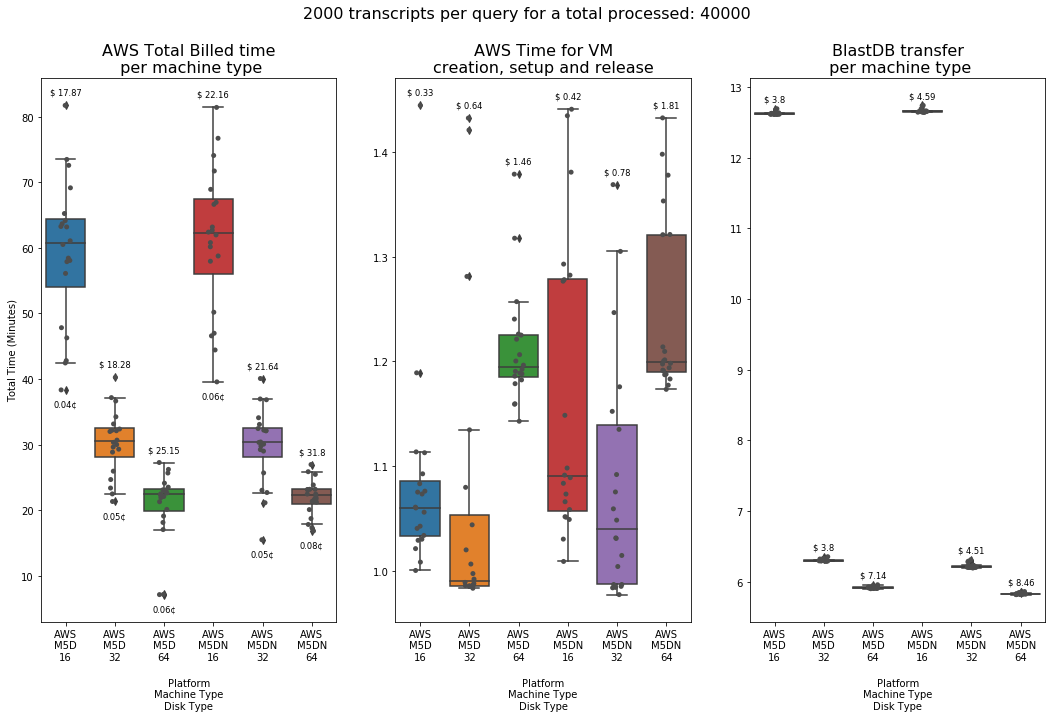

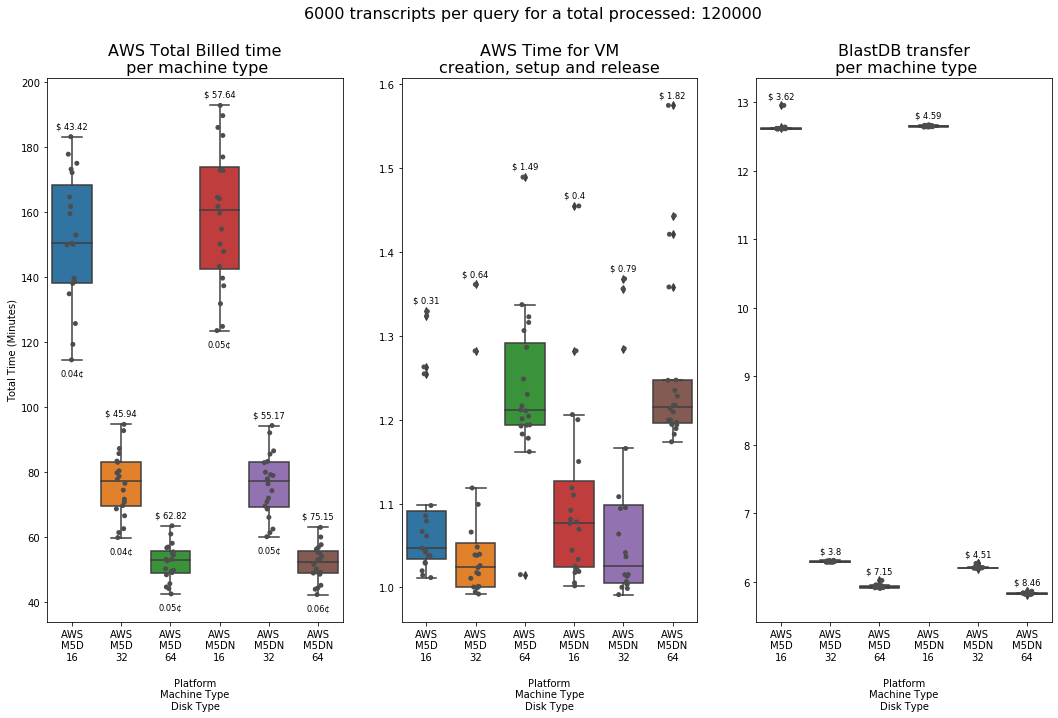

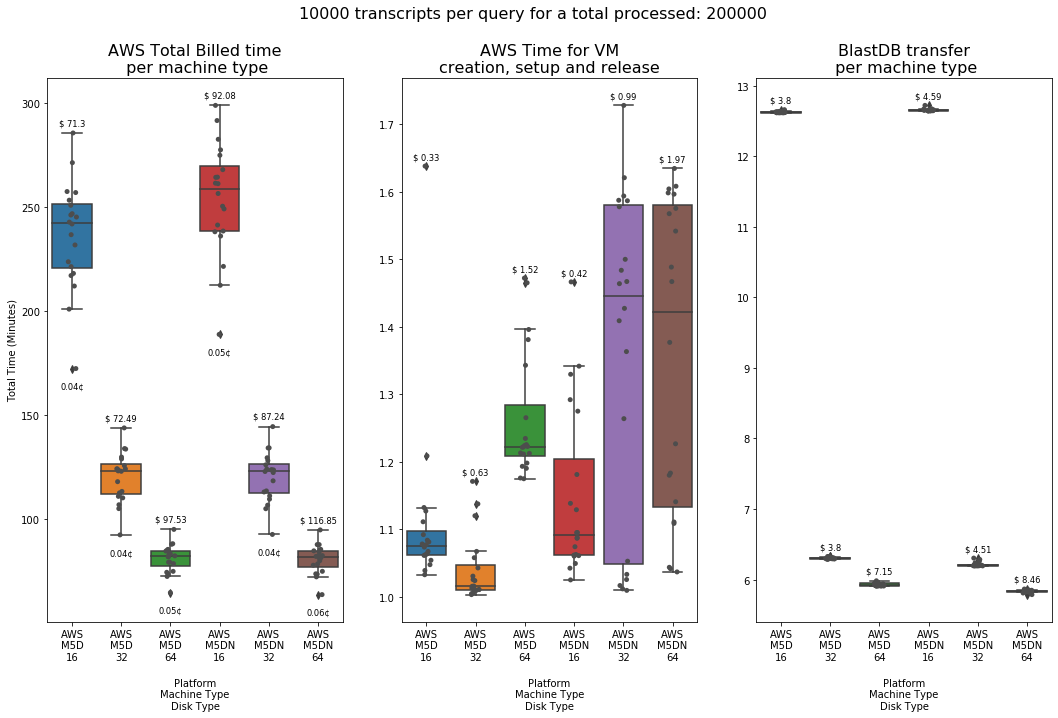

In [142]:
for q in QUERY_SIZES:
    df_total = instances[q]['total']
    df_blast = instances[q]['blast']
    df_creation = instances[q]['creation']

    fig, axs = plt.subplots(figsize=(18,10), ncols=3)

    fig.suptitle(locale.format_string("%d", int(q), grouping=True)
                         + ' transcripts per query for a total processed: ' 
                         + locale.format_string("%d", int(q) * 20, grouping=True)
                 + '\n\n', fontsize=16)

    j=0

    top = []
    low = []
    billed = []
    cost = []
    for p in df_total['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_total[df_total['Platform'] == p]['Time'].max())
        low.append(df_total[df_total['Platform'] == p]['Time'].min())
        billed.append('$ {}'.format(round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        cost.append('{:.2f}¢'.format(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])] * 100/(int(q) * 20)))


    box_plot = sns.boxplot(x="Platform", y="Time", data=df_total, ax=axs[j])
    
    top_tick = 1.6
    low_tick = 2.6
    if q == 6000:
        top_tick += 1.0
        low_tick += 2.4
    elif q == 10000:
        top_tick += 2.2
        low_tick += 7.2

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,low[xtick] - low_tick,cost[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_total, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("Total Time (Minutes)")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("AWS Total Billed time\n per machine type", fontsize=16)

    j = 1

    top = []
    billed = []
    for p in df_creation['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_creation[df_creation['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_creation, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.01,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_creation, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("AWS Time for VM\ncreation, setup and release", fontsize=16)

    j = 2

    top = []
    billed = []
    for p in df_blast['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_blast[df_blast['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_blast, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.1,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_blast, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("BlastDB transfer\n per machine type", fontsize=16)


In [145]:
!which aws

/panfs/pan1.be-md.ncbi.nlm.nih.gov/alt_splicing/cloud-transcriptome-annotation/bin/bioconda/bin/aws
